In [1]:
import numpy as np
import pandas as pd

In [2]:
from razdel import sentenize

In [3]:
import random

In [4]:
from tqdm import tqdm

In [5]:
import re
import os

In [6]:
from collections import Counter

#### For lemmatization

In [7]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

#### Visualisation

In [8]:
import matplotlib
import matplotlib.pyplot as plt

In [9]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

### Concatenate all DataFrames with sentences (from Pushkin)

In [10]:
pushkin_data_dir = '../data/prepared/pushkin'

In [11]:
data_filenames = []

for file in os.listdir(pushkin_data_dir):  # through files in selected directory            
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):  # looking for .txt files in the directory
        data_filenames.append(filename)

print(*data_filenames, sep='\n')

kapitanskaya_dochka.csv
pugachevs_story.csv
dubrovsky.csv
povesti_belkina.csv


In [12]:
pushkin_sentences_df = pd.DataFrame()
for ind, filename in enumerate(data_filenames):
    book_df = pd.read_csv(os.path.join(pushkin_data_dir, filename), index_col=0)
    print(f"{filename.split('.')[0] + ' ' * (20 - len(filename.split('.')[0]))}:\t{book_df.shape}")
    if ind == 0:
        pushkin_sentences_df = book_df
    else:       
        pushkin_sentences_df = pd.concat([pushkin_sentences_df, book_df], ignore_index=True)

print(f'\nTotal shape: {pushkin_sentences_df.shape}')

kapitanskaya_dochka :	(3033, 2)
pugachevs_story     :	(2188, 2)
dubrovsky           :	(1363, 2)
povesti_belkina     :	(1357, 2)

Total shape: (7941, 2)


In [13]:
pd.options.display.max_colwidth = 200
pushkin_sentences_df.sample(10)

,input,target
3110,войсковой атаман андрей бородин был отставлен на его место выбран петр тамбовцев члены канцелярии осуждены уплатить войску сверх удержанных денег значительную пеню но они умели избегнуть исполнени...,S S S S S C S S S S S C S S S S C S S C S C S S S S S P
2866,теперь время обедать,S S P
5675,старуха не раздевалась в эту ночь кроме приказных никто в доме не смыкал глаза,S S S S S C S S S S S S S P
5965,антон пафнутьич призывая господа в свидетели в том что красная шкатулка его была пуста не лгал и не согрешал красная шкатулка точно была пуста деньги некогда в ней хранимые перешли в кожаную суму ...,S C S S S S S C S S S S S C S S S S C S S S S C C S S S C S S S C S S S S S S P
1586,обер-секретарь продолжал мундир из тонкого зеленого сукна на семь рублей,S C S S S S S S S P
6328,дубровский как будто очнулся от усыпления,S S S S S P
7711,вот какими путями распространяется просвещение,S S S S EX
6464,исправник выслушал его со вниманием поминутно взглядывая на маленького негодяя который прикинувшись дурачком казалось не обращал никакого внимания на все что делалось около него,S S S S C S S S S C C S C S S S S S S C S S S P
1823,но все же я никак не могу дать тебе роту солдат и полсотни казаков,S S S S S S S S S S S S S P
5717,кузнец ушел пожар свирепствовал еще несколько времени,S C S S S S P


### Statistics

#### Length of sentences

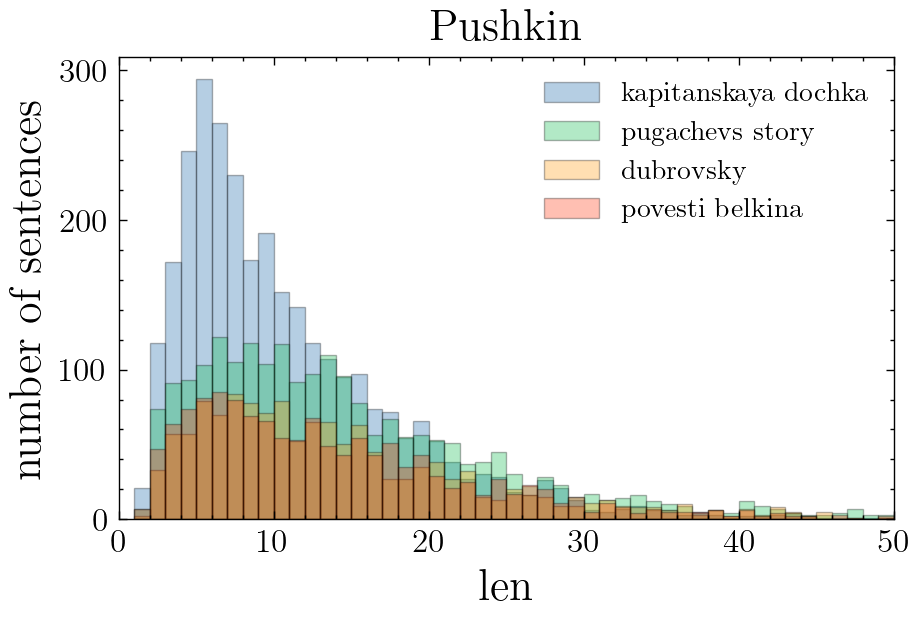

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))

for ind, filename in enumerate(data_filenames):
    book_df = pd.read_csv(os.path.join(pushkin_data_dir, filename), index_col=0)
    book_df['len'] = book_df.apply(lambda row: len(row.target.split(' ')), axis = 1)

    n_bins = int((book_df['len'].max() - book_df['len'].min()) / 1)
    pd.DataFrame.hist(
        data=book_df,
        column='len',
        ax=ax,
        bins=n_bins,
        legend=False,
        # color='lightcoral',
        alpha=0.3,
        edgecolor='k',
        lw=0.5,
        label=filename.split('.')[0].replace('_', ' ')
    )

ax.set_title('Pushkin', fontsize=lables_fs)
ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

# plt.title(None)
plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of sentences', fontsize=lables_fs)

ax.legend()
ax.grid(False)
plt.show()
# fig.savefig(f'figures/name.eps', format='eps')

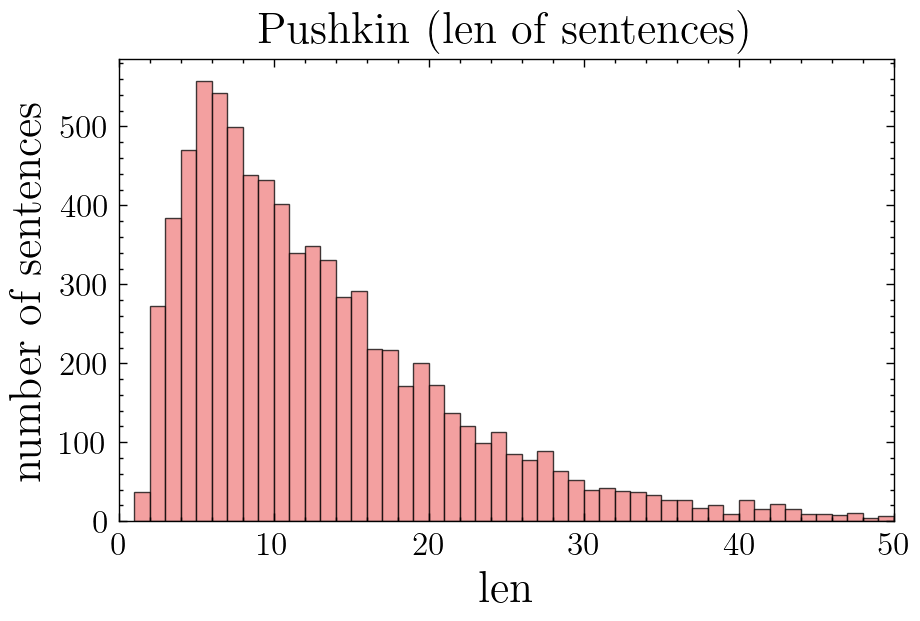

In [15]:
fig, ax = plt.subplots(figsize=(5, 3))

pushkin_sentences_df['len'] = pushkin_sentences_df.apply(lambda row: len(row.target.split(' ')), axis = 1)

n_bins = int((pushkin_sentences_df['len'].max() - pushkin_sentences_df['len'].min()) / 1)
pd.DataFrame.hist(
    data=pushkin_sentences_df,
    column='len',
    ax=ax,
    bins=n_bins,
    legend=False,
    color='lightcoral',
    alpha=0.75,
    edgecolor='k',
    lw=0.5,
)

ax.set_title('Pushkin (len of sentences)', fontsize=lables_fs)
ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of sentences', fontsize=lables_fs)

ax.grid(False)
plt.show()

# fig.savefig(f'figures/name.eps', format='eps')

In [16]:
print(f"Minimal len: {pushkin_sentences_df['len'].min()}")
print(f"Maximal len: {pushkin_sentences_df['len'].max()}")

Minimal len: 1
Maximal len: 183


In [17]:
lower_len_lim = 4
upper_len_lim = 20  # we will not use too long and too short sentences! 

len(
    pushkin_sentences_df[
        (pushkin_sentences_df['len'] >= lower_len_lim) &
        (pushkin_sentences_df['len'] <= upper_len_lim)
    ]
)

5912

#### Number of commas in sentences

In [18]:
pushkin_sentences_df['commas'] = pushkin_sentences_df.apply(
    lambda row: Counter(
        (row.target + ' C').split(' ')
    )['C'] - 1,
    axis = 1
)  # count number of commas in each target

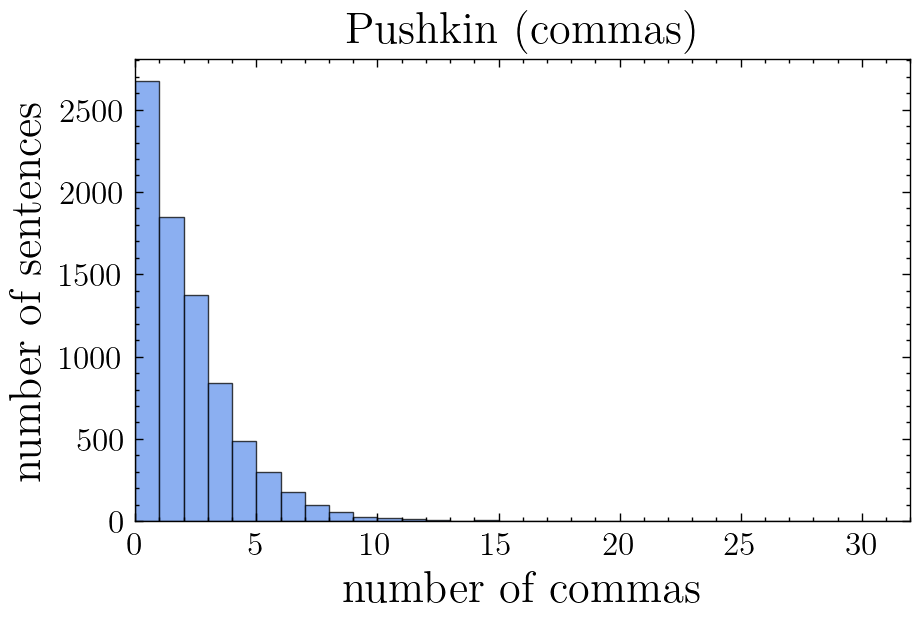

In [19]:
fig, ax = plt.subplots(figsize=(5, 3))

n_bins = int((pushkin_sentences_df['commas'].max() - pushkin_sentences_df['commas'].min()) / 1)
pd.DataFrame.hist(
    data=pushkin_sentences_df,
    column='commas',
    ax=ax,
    bins=n_bins,
    legend=False,
    color='cornflowerblue',
    alpha=0.75,
    edgecolor='k',
    lw=0.5,
)

ax.set_title('Pushkin (commas)', fontsize=lables_fs)
ax.set_xlim([0, pushkin_sentences_df['commas'].max()])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.xlabel('number of commas', fontsize=lables_fs)
plt.ylabel('number of sentences', fontsize=lables_fs)

ax.grid(False)
plt.show()

# fig.savefig(f'figures/name.eps', format='eps')

In [20]:
# number of sentences of desired length and with at least one comma in it
lower_len_lim = 3
upper_len_lim = 25

len(
    pushkin_sentences_df[
        (pushkin_sentences_df['len'] >= lower_len_lim) &
        (pushkin_sentences_df['len'] <= upper_len_lim) &
        (pushkin_sentences_df['commas'] > 0)
    ]
)

4456

### Punctuation statistics in selected Subset of the data

In [21]:
lower_len_lim = 3
upper_len_lim = 25

pushkin_data_df = pushkin_sentences_df[
    (pushkin_sentences_df['len'] >= lower_len_lim) &
    (pushkin_sentences_df['len'] <= upper_len_lim) &
    (pushkin_sentences_df['commas'] > 0)
]

print(pushkin_data_df.shape)
pushkin_data_df = pushkin_data_df.reset_index(drop=True)
pushkin_data_df.sample(5)

(4456, 4)


,input,target,len,commas
4227,вот летом проезжала барыня так та спрашивала о старом смотрителе и ходила к нему на могилу,S S S C S S S S S S S S S S S P,16,1
3086,мальчишки помирали со смеху смотря на ее отчаяние,S S S C S S S P,8,1
2219,рейнсдорп потеряв надежду победить пугачева силой оружия пустился в полемику не весьма приличную,C S S S S S C S S S S S P,13,2
4238,в молодости своей служил он в гвардии вышел в отставку в начале 1797 года уехал в свою деревню и с тех пор оттуда не выезжал,S S S S S S C S S S S S S C S S S S S S S S S S P,25,2
2674,в сию минуту салманов передался и бошняк остался с шестидесятью человеками офицеров и солдат,S S S S C S S S S S S S S P,14,1


In [22]:
all_punctuation_in_data = []

for ind_row in range(pushkin_data_df.shape[0]):
    target_this = pushkin_data_df.iloc[ind_row]['target']

    # FIXING BUGS IN PROCESS!
    if (target_this[-1] == 'C') or (target_this[-1] == 'S') or (target_this[-1] == ' '):
        # check if last mark is '.'/'!' or '?'
        print(f'{ind_row}:\t[{target_this}] --> ', end=' ')
        fixed_target_this = target_this[:-1] + 'P'
        pushkin_data_df.loc[ind_row, 'target'] = fixed_target_this
        print(f'[{fixed_target_this}]')
    if ('Q' in target_this[:-1]) or ('EX' in target_this[:-1]):
        print(f'{ind_row}:\t[{target_this}] --> ', end=' ')
        fixed_target_this = target_this[:-1].replace('EX', 'C')
        fixed_target_this = fixed_target_this.replace('Q', 'C') + target_this[-1]
        pushkin_data_df.loc[ind_row, 'target'] = fixed_target_this
        pushkin_data_df.loc[ind_row, 'target'] = fixed_target_this
        print(f'[{fixed_target_this}]')

    all_punctuation_in_data.extend(pushkin_data_df.iloc[ind_row]['target'].split(' '))

410:	[S S S C S EX S S S S Q] -->  [S S S C S C S S S S Q]
4078:	[S S C EX S S S S S S S EX] -->  [S S C C S S S S S S S EX]


In [23]:
pushkin_data_df.iloc[410]

input     нашли за что ссориться за песенку да как же это случилось
target                                        S S S C S C S S S S Q
len                                                              11
commas                                                            1
Name: 410, dtype: object

In [24]:
assert len(all_punctuation_in_data) == pushkin_data_df['len'].sum()

In [25]:
punctuation_counter = Counter(all_punctuation_in_data)

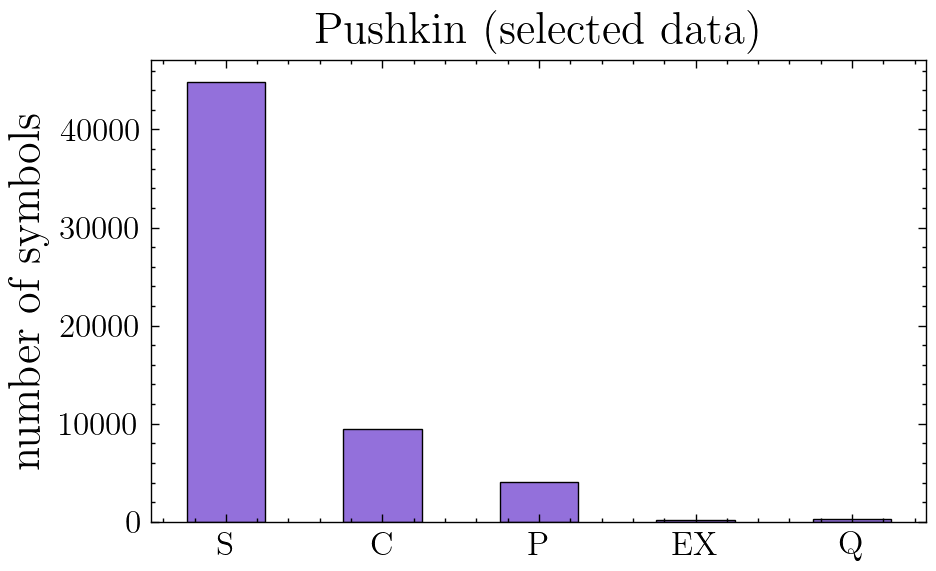

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(punctuation_counter.keys(), punctuation_counter.values(), 0.5, color='mediumpurple', edgecolor='k', lw=0.5)
ax.set_title('Pushkin (selected data)', fontsize=lables_fs)
# ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

# plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of symbols', fontsize=lables_fs)

plt.show()

#### Classes are quite unbalanced!

`Spaces` occures $\sim5$ times more frequently than `commas` in main bodies of sentences!

In [27]:
print(f"RATIO(spaces / commas) = {punctuation_counter['S'] / punctuation_counter['C']:.3f}")

RATIO(spaces / commas) = 4.744


Among __end punctuation marks__ (in the end of sentences) the ratio is the following:

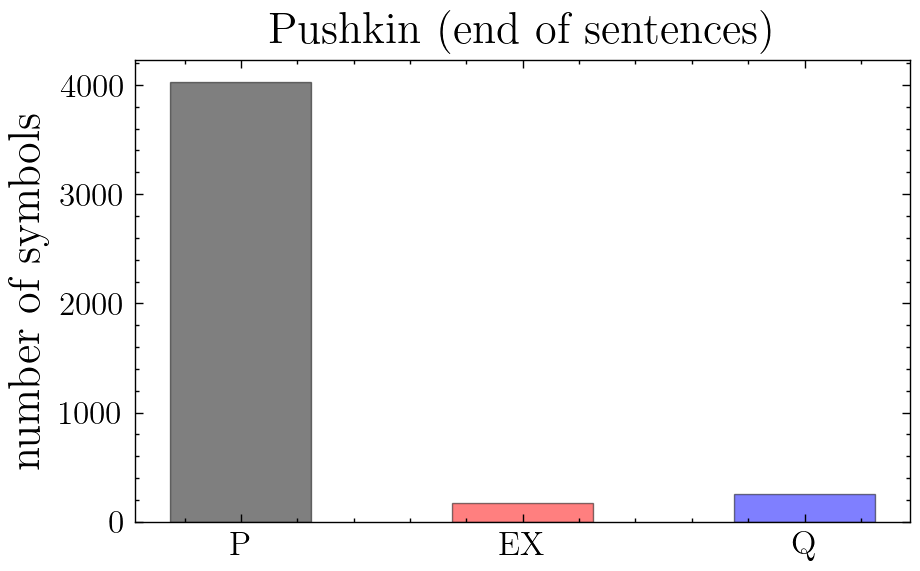

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))

keys_to_plot = ['P', 'EX', 'Q']
ax.bar(
    keys_to_plot,
    [punctuation_counter[key] for key in keys_to_plot], 
    0.5, color=['k', 'r', 'b'], edgecolor='k', lw=0.5, alpha=0.5
)
ax.set_title('Pushkin (end of sentences)', fontsize=lables_fs)
# ax.set_xlim([0, 50])

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

# plt.xlabel('len', fontsize=lables_fs)
plt.ylabel('number of symbols', fontsize=lables_fs)

plt.show()

In [29]:
dict_names = {'P': 'point', 'EX': 'exclamation', 'Q': 'question'}
sum_control = 0
for key in ['P', 'EX', 'Q']:
    n_this = punctuation_counter[key]
    sum_control += n_this
    
    print(f"{dict_names[key] + (15 - len(dict_names[key])) * ' '}: {n_this}\t({n_this / pushkin_data_df.shape[0] * 100:.2f} %)")

assert sum_control == pushkin_data_df.shape[0]

point          : 4029	(90.42 %)
exclamation    : 176	(3.95 %)
question       : 251	(5.63 %)


### Saving selected and fixed data part

In [30]:
print(pushkin_data_df.shape)
pushkin_data_df.sample(10)

(4456, 4)


,input,target,len,commas
2607,его семейство было при нем между его товарищами находились два новые лица один из них был молодой пулавский родной брат славного конфедерата,S S S S S S S S S S S C S S S S S C S S S P,22,2
1934,утром 27 сентября пугачев показался на высотах ее окружающих,S S S S S S C S P,9,1
82,нечего сказать добру наставил собачий сын,S C S C S P,6,2
2551,михельсон оставя пугачева вправе пошел прямо на казань и 11 июля вечером был уже в пятидесяти верстах от нее,C S S C S S S S S S S S S S S S S S P,19,2
3189,делать нечего написала я сыну письмо рассказала все и послала ему свое благословение без гроша денег,S C S S S C S S S S S S S S S P,16,2
2766,между тем шигаев падуров и торнов уже висели в последних содроганиях,S S C S S S S S S S P,11,1
3915,открылась сильная горячка и бедная больная две недели находилась у края гроба,S S C S S S S S S S S P,12,1
2259,2 отец его родной был той же зимовейской станицы служилый казак иван михайлов сын пугачев же который в давних годах умре,S S S S S S S S S S C S S S S C S S S S P,21,2
1060,о дело другое,C S EX,3,1
4143,он поспешно вошел в церковь священник выходил из алтаря дьячок гасил свечи две старушки молились еще в углу но дуни в церкви не было,S S S S C S S S C S S C S S S S S C S S S S S P,24,4


In [31]:
prepared_dir = '../data/prepared'
filename_csv = '01_punct_pushkin.csv'

In [32]:
# saving dataframe (only 'input' and 'target' columns)
pushkin_data_df[['input', 'target']].to_csv(os.path.join(prepared_dir, filename_csv))

## Words statistics

In [33]:
# load saved dataset
pushkin_data_df = pd.read_csv(os.path.join(prepared_dir, filename_csv), index_col=0)

In [34]:
pushkin_data_df.sample(5)

,input,target
4322,кто тебя научил этой премудрости спросил алексей расхохотавшись,S S S S C S C P
1758,местное начальство воспользовалось и сим случаем дабы новыми притеснениями мстить народу за его супротивления,S S S S S C S S S S S S S P
1799,как же могла горсть буйных казаков не только пробраться чрез такое большое расстояние и чрез тысячи неприятелей но даже поселиться между ими и грабить их,S S S S S S S S S S S S S S S S C S S S S S S S Q
1673,проходя мимо швабрина гринев остановился,S S C S P
4091,какие возникли бы споры и слуги с кого бы начинали кушанье подавать,S S S C S S S S S S S Q


In [35]:
bag_of_words = []
bag_of_numbers = []
sum_of_lengths = 0

for sentence in tqdm(pushkin_data_df['input']):
    for word in sentence.split(' '):
        sum_of_lengths += 1

        if word not in bag_of_words:
            bag_of_words.append(word)

            if any(char.isdigit() for char in word):
                bag_of_numbers.append(word)

100%|█████████████████████████████████████| 4456/4456 [00:01<00:00, 2338.96it/s]


In [36]:
print(f'Number of words with repetitions: {sum_of_lengths}')
print(f'\twithout repetitions: {len(bag_of_words)}')
print(f'\t\twith numbers: {len(bag_of_numbers)}')

Number of words with repetitions: 58773
	without repetitions: 15765
		with numbers: 88


### [`natasha`](https://github.com/natasha/natasha)

#### Example

In [37]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [38]:
# sent_ex = 'кирила петрович взбесился насилу князь мог уговорить его не показывать маше и виду что он уведомлен о ее письме'
sent_ex = 'как увидишь его страх и трепет и краплет пот  а спина-то сама так и гнется так и гнется'

doc_ex = Doc(sent_ex)

doc_ex.segment(segmenter)
doc_ex.tag_morph(morph_tagger)

In [39]:
for token in doc_ex.tokens:
    token.lemmatize(morph_vocab)

In [40]:
{_.text: _.lemma for _ in doc_ex.tokens}

{'как': 'как',
 'увидишь': 'увидеть',
 'его': 'его',
 'страх': 'страх',
 'и': 'и',
 'трепет': 'трепет',
 'краплет': 'крапать',
 'пот': 'пот',
 'а': 'а',
 'спина-то': 'спина-то',
 'сама': 'сам',
 'так': 'так',
 'гнется': 'гнется'}

In [68]:
{token.text: token.pos for token in doc_ex.tokens}

{'как': 'SCONJ',
 'увидишь': 'VERB',
 'его': 'DET',
 'страх': 'NOUN',
 'и': 'PART',
 'трепет': 'NOUN',
 'краплет': 'ADJ',
 'пот': 'NOUN',
 'а': 'CCONJ',
 'спина-то': 'NOUN',
 'сама': 'ADJ',
 'так': 'ADV',
 'гнется': 'ADV'}

#### Lemmatize all sentences and form a new bag of words

In [93]:
bag_of_lemmas = []
bag_of_pos = []
exc = 0

# prepare another inputs for prediction
all_lemmas_inputs = []  # sentences as sequences of lemmas!
all_pos_inputs = []  # sentences as sequences of speech parts

for sentence in tqdm(pushkin_data_df['input']):
    len_sent = len(sentence.split(' '))

    doc_sent = Doc(sentence)
    doc_sent.segment(segmenter)
    doc_sent.tag_morph(morph_tagger)

    num_lemmas = 0
    for token in doc_sent.tokens:
        token.lemmatize(morph_vocab)

        num_lemmas += 1
        lemma = token.lemma
        pos = token.pos
        
        if lemma not in bag_of_lemmas:
            bag_of_lemmas.append(lemma)

        if pos not in bag_of_pos:
            bag_of_pos.append(pos)

    all_lemmas_inputs.append(' '.join([token.lemma for token in doc_sent.tokens]))
    all_pos_inputs.append(' '.join([token.pos for token in doc_sent.tokens]))

    assert len(all_lemmas_inputs[-1].split(' ')) == len_sent
    assert len(all_pos_inputs[-1].split(' ')) == len_sent
    
    try:
        assert len_sent == num_lemmas
    except AssertionError:
        exc += 1
        print(f'{exc}.\t' + sentence)  # if sentence has some problems

100%|██████████████████████████████████████| 4456/4456 [00:20<00:00, 219.50it/s]


In [94]:
print(f'Number of different words : {len(bag_of_words)}')
print(f'Number of different lemmas: {len(bag_of_lemmas)}')

Number of different words : 15765
Number of different lemmas: 8569


In [95]:
print(random.sample(bag_of_lemmas, 50))  # random 50 lemmas

['новобраный', 'утверждая', 'безделица', 'мы-то', 'морской', 'плетей', 'государев', 'шкатулка', 'плыть', 'немаловажный', 'чуваш', 'гугниха', 'видали', 'удержание', 'беглый', 'пленный', 'вольность', 'приходиться', 'грешный', 'клик', 'прильнув', 'заунывный', 'юрка', 'спокойнее', 'ввелось', 'просить', 'медлить', 'замечательна', 'булочнику', 'отчаянно', 'фирска', 'сатанин', 'пивоваров', 'обер-полицеймейстер', 'не', 'клялисить', 'сделалось', 'наступательный', 'ввинтить', 'деревцо', 'мир', 'предложение', 'турцией', 'уединение', 'остолбенеть', 'троекур', 'предубеждение', 'аки', 'нога', 'разбить']


In [96]:
# add another forms of input in dataframe
pushkin_data_df['input_lemma'] = all_lemmas_inputs
pushkin_data_df['input_pos'] = all_pos_inputs

In [98]:
pushkin_data_df = pushkin_data_df[sorted(pushkin_data_df.columns.values)]
pushkin_data_df.sample(5)

,input,input_lemma,input_pos,target
560,слушайте что пишет генерал,слушать что писать генерал,VERB PRON VERB NOUN,C S S P
1232,вдруг увидел я деревушку на крутом берегу яика с частоколом и с колокольней и через четверть часа въехали мы в белогорскую крепость,вдруг увидеть я деревушка на крутой берег яик с частокол и с колокольня и через четверть час въехать мы в белогорский крепость,ADV VERB PRON NOUN ADP ADJ NOUN NOUN ADP NOUN CCONJ ADP NOUN CCONJ ADP NOUN NOUN VERB PRON ADP ADJ NOUN,S S S S S S S C S S S S C S S S S S S S S P
2205,жена пугачева сын и две дочери были отосланы в казань куда отправлен и родной его брат служивший казаком во второй армии,жена пугачев сын и два дочь быть отослать в казань куда отправить и родной он брат служить казак в второй армия,NOUN NOUN NOUN CCONJ NUM NOUN AUX VERB ADP NOUN ADV VERB PART ADJ PRON NOUN VERB NOUN ADP ADJ NOUN,S C S S S S S S S C S S S S S C S S S S P
2975,ах батька и мы хотели зазвать весь околоток да владимир андреевич не захотел,ах батька и мы хотеть зазвать весь околоток да владимир андреевич не захотеть,PART NOUN CCONJ PRON VERB VERB DET NOUN CCONJ VERB NOUN PART VERB,C C S S S S S C S S S S P
1711,долго смотрел я издали на сельский дом опять мною покидаемый,долго смотреть я издали на сельский дом опять я покидать,ADV VERB PRON ADV ADP ADJ NOUN ADV PRON ADJ,S S S S S S C S S P


In [99]:
# saving dataframe with new inputs
pushkin_data_df.to_csv(os.path.join(prepared_dir, filename_csv))

#### Parts of speech

Some punctuation rules are driven by words' parts of speech and by their order.

In [77]:
print('All parts of speech in russian:')
print(*bag_of_pos)

All parts of speech in russian:
ADP DET NOUN VERB PRON ADJ ADV CCONJ AUX SCONJ PART X NUM PROPN PUNCT


In [78]:
len(bag_of_pos)  # as a aseline we will try to use `sequences of parts of speech` as input

15